# Gradient verification for the 2D - non reactive transport (diffusion + advection), permeablity inversion from head - density flow

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [28]:
import copy
import logging
import os
from pathlib import Path
from typing import Iterable

import gstools as gs
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pandas as pd
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from IPython.display import HTML
from matplotlib.animation import HTMLWriter

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [30]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test



- Check package/software versions

In [ ]:
pyrtid.utils.show_verisons()

- Create a directory to store the exported figures

In [32]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [33]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure transient density flow + transport (advection & diffusion) case in 2D.

In [34]:
nx = 21  # number of voxels along the x axis
ny = 8  # number of voxels along the y axis
nz = 1  # number of voxels along the y axis
# Give non regular dimensions to check if all is correct with mesh dimensions
dx = 8.43  # voxel dimension along the x axis
dy = 5.6
dz = 1.5  # voxel dimension along the y axis

nt = 5  # number of time steps
dt = 3600 * 6  # timestep in seconds
c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-8  # general initial diffusion coefficient [m2/s]
k0 = 1e-3  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 1  # molal

storage_coefficient: float = 1e-4

initial_head_in_m = 100.0  # m
cst_head_left = 0.0  # 9.3  # m
cst_head_right = 0.0  # -5.5  # m

flow_regime = "transient"

crank_flow = 0.8
crank_diff = 1.0
crank_adv = 0.5

# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

- Three observation wells

In [35]:
well_length = 1.0
production_locations = [(6, 3, 0), (14, 3, 0)]
injection_locations = [(2, 6, 0), (10, 6, 0), (18, 6, 0)]

- Create an initial "bumped" reference distribution for the permeability, and a flat one for the initial estimation.

In [36]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 19

min_val = 0.1
max_val = 0.5
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
meanlog = (max_val + min_val) / 2.0
stdevlog = (max_val - min_val) / 4.0  # std ~ 1/6 of the distribution interval
len_scale: float = 2.0

mean = get_normalized_mean_from_lognormal_params(meanlog, stdevlog)
stdev = get_normalized_std_from_lognormal_params(meanlog, stdevlog)

poro_reference = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    normalizer=gs.normalizer.LogNormal,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    nz=nz,
    seed=seed,
)[0, :, :, 0]


# Initial estimate = an homogeneous value
poro_estimate = np.ones((nx, ny)) * 0.2  # fraction

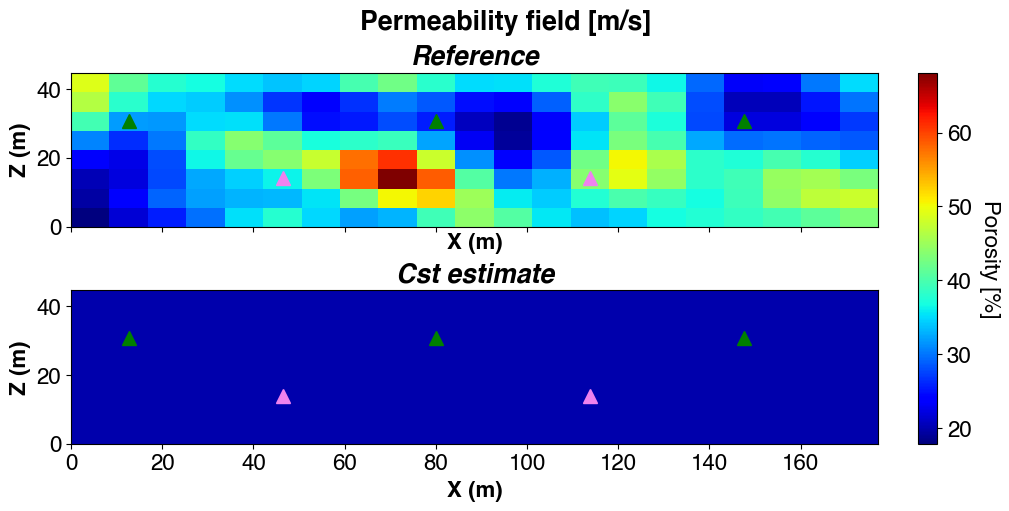

In [37]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": poro_reference * 100,
        "Cst estimate": poro_estimate * 100,
    },
    cbar_title="Porosity [%]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Z [m]",
)

plotter.subfigs["fig0"].suptitle("Permeability field [m/s]", fontweight="bold")

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx - dx / 2,
            well_pos[1] * dy - dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx - dx / 2,
            well_pos[1] * dy - dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

fname = "true_vs_estimated_initial_mineral_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Create the flowrates for the wells: 12 m3/h decreasing following an exponential... for the producers with a balanced injection (2 m3/h per associated cell for the injectors).

In [38]:
def gen_flowrates(amplitude: float, coef: float, nt: int, dt: float) -> NDArrayFloat:
    """Generate flowrates with a given amplitude and decrease coefficient.

    Parameters
    ----------
    amplitude : float
        Amplitude in m3/h.
    coef : float
        Decrease coefficient.
    nt : int
        Number of timesteps
    dt : float
        Timesteps.

    Returns
    -------
    np.ndarray
        The flowrates.
    """
    return amplitude * np.exp(coef * np.arange(nt) * dt)

- Generate a flowrates with an initial amplitude at 1 m3/h and plot it

Text(0.5, 0, 'time [d]')

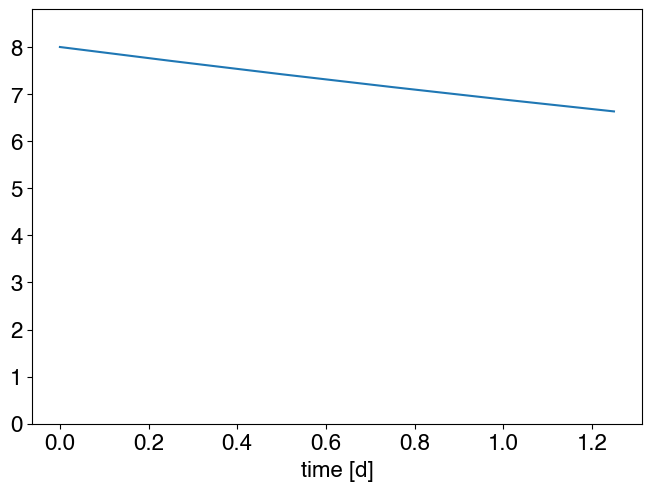

In [39]:
init_prod_flowrates = 8.0  # m3/s
# nt+1 because we consider the initial state too
flowrates = init_prod_flowrates * gen_flowrates(
    1.0, -0.15, nt + 1, dt=dt / 3600 / 24
)  # m3/s

plt.plot(np.arange(nt + 1) * dt / 3600 / 24, flowrates)
plt.ylim(0.0, init_prod_flowrates * 1.1)
plt.xlabel("time [d]")

### Forward problem definition in PyRTID

In [40]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy, dz=dz)
fl_params = dmfwd.FlowParameters(
    permeability=k0,
    storage_coefficient=storage_coefficient,
    regime={
        "stationary": dmfwd.FlowRegime.STATIONARY,
        "transient": dmfwd.FlowRegime.TRANSIENT,
    }[flow_regime],
    crank_nicolson=crank_flow,
    vertical_axis=dmfwd.VerticalAxis.DY,  # the y axis is the vertical
)
tr_params = dmfwd.TransportParameters(
    diffusion=D0,
    porosity=w0,
    crank_nicolson_diffusion=crank_diff,
    crank_nicolson_advection=crank_adv,
)
gch_params = dmfwd.GeochemicalParameters(conc=c0)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Add boundary conditions

In [41]:
# Boundary conditions
base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
base_model.fl_model.head[0, :, :] = initial_head_in_m
base_model.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
base_model.fl_model.head[-1, :, :] = initial_head_in_m

base_model.fl_model.head[:, :, 0] = initial_head_in_m

- Add source and sink terms

In [42]:
prod_flw = -flowrates / 3600  # m3/h to m3/s
times = np.arange(stop=nt + 1, start=0) * dt

# two successive pumping on days 1 and 2
for loc in production_locations:
    sink_term = dmfwd.SourceTerm(
        f"producer loc # {loc}",
        node_ids=np.array(indices_to_hytec_node_number(loc[0], nx=nx, iy=loc[1])),
        # pumping on 1 day
        times=times,
        flowrates=prod_flw,
        concentrations=np.zeros(times.shape),
    )
    base_model.add_src_term(sink_term)

n_prod_linked_list = [1, 2, 1]

# three successive injections on days 3, 4 and 5
for count_inj, loc in enumerate(injection_locations):
    source_term = dmfwd.SourceTerm(
        "injector loc # {loc}",
        node_ids=np.array(indices_to_hytec_node_number(loc[0], nx=nx, iy=loc[1])),
        times=times,
        flowrates=-n_prod_linked_list[count_inj] * prod_flw / 2,
        concentrations=np.ones(times.shape) * c_inj,  # injection concentration
    )
    base_model.add_src_term(source_term)

- Create two models

In [43]:
model_reference = copy.deepcopy(base_model)
model_estimate = copy.deepcopy(base_model)
# Reference
model_reference.tr_model.porosity = poro_reference.reshape(nx, ny)
# Estimated diffusion
model_estimate.tr_model.porosity = poro_estimate.reshape(nx, ny)
model_reference.tr_model.set_initial_conc(c0)
model_estimate.tr_model.set_initial_conc(c0)

- Run the models

In [44]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

In [45]:
solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

### Forward problem definition in HYTEC

- Create an empty simulation in a non existing folder

In [46]:
simu_base = HytecSimulation("simu_base", Path.cwd().joinpath("simu_base"))

- Add a TDB file

In [47]:
simu_base.link_tdb("./../../../../../TDB/chess.tdb")  # This is relative to the htc file

- Define the output format

In [48]:
simu_base.model.add_sub_item(hymd.OutputFormat("vtk"))

- By pass the chemistry which is not needed here

In [49]:
simu_base.model.add_sub_item(hymd.TalkSat("enabled"))

- Hydrodynamic model and its parameters definition


In [50]:
hmodel = hymd.HydrodynamicModel(
    hymd.FlowRegime(flow_regime),
    hymd.Porosity(w0),
    hymd.Permeability(k0, units="m/s"),
    hymd.DiffusionCoefficient(D0, units="m2/s"),
    hymd.Head(initial_head_in_m, "m"),
    hymd.FlowCrankNicolson(crank_flow),
    hymd.AdvectionCrankNicolson(crank_adv),
    hymd.DiffusionCrankNicolson(crank_diff),
    hymd.StorageCoefficient(storage_coefficient),
)
simu_base.model.add_sub_item(hmodel)

- Geochemical unit definition

In [51]:
chmodel = hymd.GeochemicalModel(hymd.Report("full"), hymd.Redox("disabled"))
# Define a geochem unit
base_unit = hymd.GeochemicalUnit("chem_base")
inj_unit = hymd.GeochemicalUnit("injected_solution")
species = "T"
# Set concentrations
base_unit.add_sub_item(hymd.Concentration(species, c0, units="molal"))
inj_unit.add_sub_item(hymd.Concentration(species, c_inj, units="molal"))
# define tracer
chmodel.add_sub_item(hymd.Define("basis", species, hymd.MoleWeight(270.028, "g/mol")))

# exclude
chmodel.add_sub_item(hymd.Exclude(("minerals", "colloids", "gases")))

# Add the units to the geochemical model
chmodel.add_sub_item(base_unit)
chmodel.add_sub_item(inj_unit)

# bypass the chemistry to get faster
chmodel.add_sub_item(hymd.ChemistryBypass("enabled"))

# Add to the main model
simu_base.model.add_sub_item(chmodel)

- Geometry definition

In [52]:
gmodel = hymd.GeometryModel(
    # hymd.GridRegime("rectangle 3D"), hymd.Domain(f"{nx*dx},{nx} {ny*dy},{ny} {nz*dz},{nz}")
    hymd.GridRegime("rectangle 3D"),
    hymd.Domain(f"{nx*dx},{nx} {ny*dy},{ny} {nz*dz},{nz}"),
)
zone_domain = hymd.Zone(
    "domain", hymd.Geometry("domain"), hymd.Geochemistry(base_unit.name)
)
gmodel.add_sub_item(zone_domain)

- Boundary model definition

In [53]:
zone_border = hymd.Zone(
    "border",
    hymd.Geometry(
        f"rectangle {dx/2},{ny * dy / 2},{dz/2} {dx},{ny * dy},{dz}",
        units="m",
    ),
    hymd.Geometry(
        f"rectangle {(nx - 0.5) * dx},{ny * dy/2},{dz/2} {dx},{ny * dy},{dz}",
        units="m",
    ),
    hymd.Geochemistry(base_unit.name),
    hymd.Head(initial_head_in_m, "m"),
    hymd.FlowConstraint(f"constant-head at {initial_head_in_m} m"),
)
gmodel.add_sub_item(zone_border)

In [54]:
simu_base.model.add_sub_item(gmodel)

- Time discretization

In [55]:
tmodel = hymd.TimeDiscretizationModel(
    hymd.Duration(nt * dt, units="s"),
    hymd.TimeStep(
        hymd.Variable(
            hymd.StartValue(dt, "s"), hymd.Maximum(dt, "s"), hymd.CourantFactor(20.0)
        ),
    ),
)
simu_base.model.add_sub_item(tmodel)

- Sampling definition

In [56]:
# Sampling model
smodel = hymd.SamplingModel(
    hymd.GridSampling(nt),
    hymd.Select("time", units="s"),
    hymd.Select("node-number"),
    hymd.Select("flowrate", units="m/s"),
    hymd.Select("permeability", units="m/s"),
    hymd.Select("head", units="m"),
    hymd.Select("porosity"),
    hymd.Select("diffusion"),
    hymd.Select("pressure", units="bar"),
    hymd.Select("density", units="kg/m3"),
    hymd.Select("T", units="mol/kg"),
)
simu_base.model.add_sub_item(smodel)

- Create the injection/pumping file: 1 column per well + 1 column for the time (days)

In [57]:
src_term_path: str = "MODIFY/source_terms.dat"
src_term_data: NDArrayFloat = np.zeros(
    (nt, len(injection_locations) + len(production_locations) + 1)
)
src_term_data[:, 0] = np.arange(stop=nt, start=0) * dt

- Create one zone per well with the correct flowrates: negative for producers and positive for injectors.

In [58]:
# 1) Add the producer wells
count_prod: int = 0  # to avoid unbounded values in the next loop
for count_prod, (ix, iy, iz) in enumerate(production_locations):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz
    name = f"producer_{ix}_{iy}_{iz}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {x},{y},{z} {dx},{dy},{dz}",
            units="m",
        )
    )
    zone.add_sub_item(hymd.Geochemistry(base_unit.name))
    zone.add_sub_item(hymd.GlobalFlux(name))
    zone.add_sub_item(
        hymd.Source(-flowrates[0], units="m3/h", geochem_unit=inj_unit.name)
    )
    zone.add_sub_item(
        hymd.Modify(
            "$1",
            hymd.Source(
                f"${count_prod+2}",
                units="m3/h",
                geochem_unit=inj_unit.name,
                src_file_path=src_term_path,
            ),
            time_units="s",
        )
    )
    simu_base.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)
    # Update the src_terms file -> 2 m3/h for a producer
    src_term_data[:, count_prod + 1] = -flowrates[1:]

n_prod_linked_list = [1, 2, 1]

# 2) Add the injector wells
for count_inj, (ix, iy, iz) in enumerate(injection_locations):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz
    name = f"injector_{ix}_{iy}_{iz}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {x},{y},{z} {dx},{dy},{dz}",
            units="m",
        )
    )
    zone.add_sub_item(hymd.Geochemistry(base_unit.name))
    zone.add_sub_item(hymd.GlobalFlux(name))
    zone.add_sub_item(
        hymd.Source(
            f"{n_prod_linked_list[count_inj] * flowrates[0] / 2}",
            units="m3/h",
            geochem_unit=inj_unit.name,
        ),
    )
    zone.add_sub_item(
        hymd.Modify(
            "$1",
            hymd.Source(
                f"${count_prod + count_inj +3}",
                units="m3/h",
                geochem_unit=inj_unit.name,
                src_file_path=src_term_path,
            ),
            time_units="s",
        )
    )
    simu_base.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)

    src_term_data[:, count_prod + count_inj + 2] = (
        +flowrates[1:] * n_prod_linked_list[count_inj] / 2
    )

# 3) Add the src_data_file (need to write and read the file... which is a bit stupid...)
# Register the source data file
# Note: need a high number of digits to get something strictly equivalent with the demonstrator
simu_base.register_modifiy_src_file(src_term_path, src_term_data, fmt="%.6f")

- Define a runner

In [63]:
if runner_type == RunnerType.FRONTAL:
    runner = FrontalHytecRunner(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        nb_cpu=4,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.SLURM:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=4,
        queue="geo-cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = SlurmHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.QSUB:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=4,
        queue="Omines_cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = QsubHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
else:
    raise Exception("Could not created runner")

- Create 2 models from this base simulation

In [64]:
simu_reference = copy.deepcopy(simu_base)
simu_reference.update_root_and_name(
    new_root="simu_reference", new_name="simu_reference"
)
simu_estimate = copy.deepcopy(simu_base)
simu_estimate.update_root_and_name(new_root="simu_estimate", new_name="simu_estimate")

- Add the permeability fields to the simulations

In [65]:
index: NDArrayInt = np.arange(nx * ny * nz)

x, y, z = hytec_node_number_to_indices(index, nx=nx, ny=ny)

In [66]:
poro_reference.size

168

In [67]:
# True
data_true = pd.DataFrame(
    data={
        "node-number": index,
        "permeability": k0,
        "porosity": poro_reference.ravel("F"),
        "diffusion": D0,
    },  # need to flatten the parameter
    index=index,
)
simu_reference.add_param_file_data(ParameterFiles.HYDRO, data_true)

# Estimated
data_estimated = pd.DataFrame(
    data={
        "node-number": index,
        "permeability": k0,
        "porosity": poro_estimate.ravel("F"),
        "diffusion": D0,
    },  # need to flatten the parameter
    index=index,
)
simu_estimate.add_param_file_data(ParameterFiles.HYDRO, data_estimated)

- Checking the hydro parameters have been correctly set-up

In [68]:
simu_reference.handlers.hydro.data

,node-number,permeability,porosity,diffusion
0,0,0.001,0.178831,1.000000e-08
1,1,0.001,0.216694,1.000000e-08
2,2,0.001,0.257069,1.000000e-08
3,3,0.001,0.296843,1.000000e-08
4,4,0.001,0.353517,1.000000e-08
...,...,...,...,...
163,163,0.001,0.292913,1.000000e-08
164,164,0.001,0.233055,1.000000e-08
165,165,0.001,0.241312,1.000000e-08
166,166,0.001,0.302483,1.000000e-08


In [69]:
simu_estimate.handlers.hydro.data

,node-number,permeability,porosity,diffusion
0,0,0.001,0.2,1.000000e-08
1,1,0.001,0.2,1.000000e-08
2,2,0.001,0.2,1.000000e-08
3,3,0.001,0.2,1.000000e-08
4,4,0.001,0.2,1.000000e-08
...,...,...,...,...
163,163,0.001,0.2,1.000000e-08
164,164,0.001,0.2,1.000000e-08
165,165,0.001,0.2,1.000000e-08
166,166,0.001,0.2,1.000000e-08


- Create two more models with the density flow

In [70]:
simu_reference_density = copy.deepcopy(simu_reference)
simu_reference_density.update_root_and_name(
    new_root="simu_reference_density", new_name="simu_reference_density"
)
simu_reference_density.model.get_sub_model(hymd.HydrodynamicModel).add_sub_item(
    hymd.FlowRegime(f"density-flow, {flow_regime}"), is_verbose=False
)

simu_estimate_density = copy.deepcopy(simu_estimate)
simu_estimate_density.update_root_and_name(
    new_root="simu_estimate_density", new_name="simu_estimate_density"
)
simu_estimate_density.model.get_sub_model(hymd.HydrodynamicModel).add_sub_item(
    hymd.FlowRegime(f"density-flow, {flow_regime}"), is_verbose=False
)

In [71]:
simu_reference.write_input_files()
simu_estimate.write_input_files()
simu_reference_density.write_input_files()
simu_estimate_density.write_input_files()
runner.run(simu_reference)
runner.run(simu_estimate)
runner.run(simu_reference_density)
runner.run(simu_estimate_density)

INFO:root:The job is over ! Elapsed time = 0:00:00.245555
INFO:root:The job is over ! Elapsed time = 0:00:00.236318
INFO:root:The job is over ! Elapsed time = 0:00:00.316749
INFO:root:The job is over ! Elapsed time = 0:00:00.255010


True

### Forward problem results

- Reading the results for the reference diffusion simulation

In [72]:
runner

FrontalHytecRunner(hytec_binary_path_or_alias='hytec', mpi_binary_path_or_alias='mpiexec', nb_cpu=4, freq_checks_is_simu_over_sec=5)

In [73]:
simu_reference.read_hytec_results()
simu_reference.handlers.results.grid_res_columns

['timestep',
 'Zones',
 'time [s]',
 'node-number []',
 'x-flowrate [m/s]',
 'y-flowrate [m/s]',
 'z-flowrate [m/s]',
 'permeability [m/s]',
 'head [m]',
 'porosity []',
 'diffusion [m2/s]',
 'pressure [bar]',
 'density [kg/m3]',
 'T [mol/kg]',
 'flowrate',
 'x-distance',
 'y-distance']

In [79]:
fwd_conc_reference_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="T [mol/kg]", nx=nx, ny=ny, nz=nz
)
poro_reference_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="porosity []", nx=nx, ny=ny, nz=nz
)
head_reference_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="head [m]", nx=nx, ny=ny, nz=nz
)
# flowrate_reference_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
#     field="flowrate [m/s]", nx=nx, ny=ny, nz=nz
# )
x_flowrate_reference_hytec = (
    simu_reference.handlers.results.extract_field_from_grid_res(
        field="x-flowrate [m/s]", nx=nx, ny=ny, nz=nz
    )
)
y_flowrate_reference_hytec = (
    simu_reference.handlers.results.extract_field_from_grid_res(
        field="y-flowrate [m/s]", nx=nx, ny=ny, nz=nz
    )
)
z_flowrate_reference_hytec = (
    simu_reference.handlers.results.extract_field_from_grid_res(
        field="z-flowrate [m/s]", nx=nx, ny=ny, nz=nz
    )
)
pressure_reference_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="pressure [bar]", nx=nx, ny=ny, nz=nz
)
density_reference_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="density [kg/m3]", nx=nx, ny=ny, nz=nz
)
# Getting sample time. The unit is the same than the one defined for the simulation duration in the htc
grid_sample_times = simu_reference.handlers.results.get_sample_times_from_grid_res()

- Reading the results for the estimated permeability simulation

In [80]:
simu_estimate.read_hytec_results()
simu_estimate.handlers.results.grid_res_columns

['timestep',
 'Zones',
 'time [s]',
 'node-number []',
 'x-flowrate [m/s]',
 'y-flowrate [m/s]',
 'z-flowrate [m/s]',
 'permeability [m/s]',
 'head [m]',
 'porosity []',
 'diffusion [m2/s]',
 'pressure [bar]',
 'density [kg/m3]',
 'T [mol/kg]',
 'flowrate',
 'x-distance',
 'y-distance']

In [83]:
# Get the results on a 3D grid with the last dimension as time step
fwd_conc_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="T [mol/kg]", nx=nx, ny=ny, nz=nz
)
poro_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="porosity []", nx=nx, ny=ny, nz=nz
)
head_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="head [m]", nx=nx, ny=ny, nz=nz
)
# flowrate_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
#     field="flowrate [m/s]", nx=nx, ny=ny, nz=nz
# )
x_flowrate_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="x-flowrate [m/s]", nx=nx, ny=ny, nz=nz
)
y_flowrate_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="y-flowrate [m/s]", nx=nx, ny=ny, nz=nz
)
z_flowrate_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="z-flowrate [m/s]", nx=nx, ny=ny, nz=nz
)
pressure_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="pressure [bar]", nx=nx, ny=ny, nz=nz
)
density_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="density [kg/m3]", nx=nx, ny=ny, nz=nz
)

### Permeability field

- Check the permeability

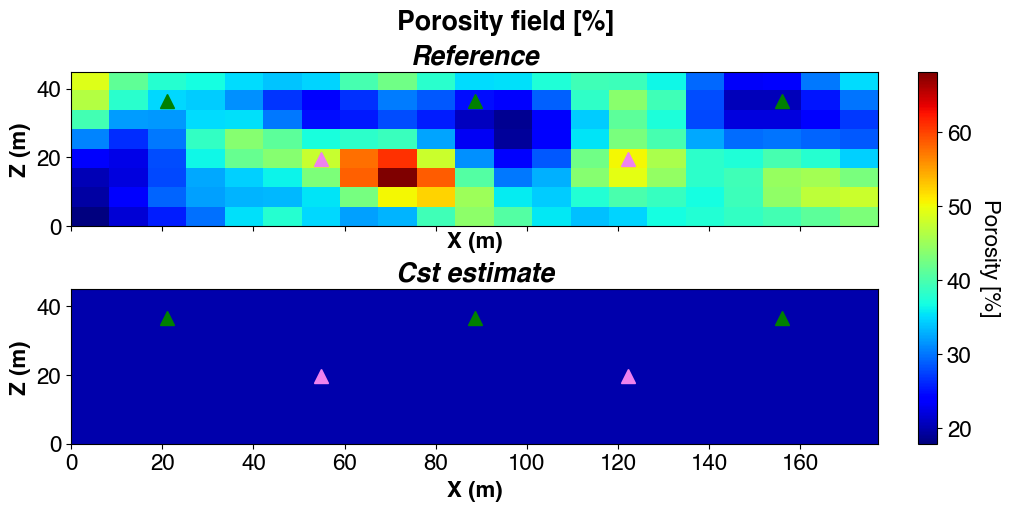

In [84]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": poro_reference_hytec[:, :, 0, 0] * 100,
        "Cst estimate": poro_estimate_hytec[:, :, 0, 0] * 100,
    },
    cbar_title="Porosity [%]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Z [m]",
)

plotter.subfigs["fig0"].suptitle("Porosity field [%]", fontweight="bold")

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

fname = "true_vs_estimated_initial_mineral_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Head, pressure, and darcy velocities

- spatial evolution of heads

In [85]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 10)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"], ["ax1-4"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_reference.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.fl_model.head[:, :, :],
        "Reference (HYTEC)": head_reference_hytec[:, :, 0, :],
        "Initial guess (PyRTID)": model_estimate.fl_model.head[:, :, :],
        "Initial guess (HYTEC)": head_estimate_hytec[:, :, 0, :],
    },
    cbar_title="Head [m]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [86]:
head_estimate_hytec[:, :, 0, 0]

array([[100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100.,

- Pressure evolution

In [87]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 10)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"], ["ax1-4"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_reference.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.fl_model.get_pressure_pa()[:, :, :] / 1e5,
        "Reference (HYTEC)": pressure_reference_hytec[:, :, 0, :],
        "Initial guess (PyRTID)": model_reference.fl_model.get_pressure_pa()[:, :, :]
        / 1e5,
        "Initial guess (HYTEC)": pressure_estimate_hytec[:, :, 0, :],
    },
    cbar_title="Pressure [bar]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("Pressure [bar]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "pressure_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Concentration evolution

In [88]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"], ["ax1-4"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_reference.time_params.nt, 15)


plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.tr_model.conc[:, :, :],
        "Reference (HYTEC)": fwd_conc_reference_hytec[:, :, 0, :],
        "Initial guess (PyRTID)": model_reference.tr_model.conc[:, :, :],
        "Initial guess (HYTEC)": fwd_conc_estimate_hytec[:, :, 0, :],
    },
    cbar_title="Tracer concentration [molal]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Z [m]",
    nb_frames=nb_frames,
)

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

plotter.subfigs["fig0"].suptitle("Tracer concentration [molal]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "concentration_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Density evolution

In [89]:
# plotter = ngp.AnimatedPlotter(
#     fig_params={"constrained_layout": True, "figsize": (15, 12)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"], ["ax1-4"]], sharey=True, sharex=True)
#     },
# )

# nb_frames=min(nt +1, 15)


# plotter.animated_multi_imshow(
#     ax_names=["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
#     fig=plotter.fig,
#     data={
#         # Warning: observation 0 matches sample 1
#         "Reference": density_reference_hytec[:, :, 0, :],
#         "Reference - density": density_reference_density_hytec[:, :, 0, :],
#         "Initial guess": density_estimate_hytec[:, :, 0, :],
#         "Initial guess - density": density_estimate_density_hytec[:, :, 0, :],
#     },
#     cbar_title="Tracer concentration [molal]",
#     imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
#     xlabel="X [m]",
#     ylabel="Z [m]",
#     nb_frames=nb_frames,
# )

# for ax in plotter.ax_dict.values():
#     # Add some vertical lines to indicate the well
#     for well_pos in production_locations:
#         ax.plot(
#             well_pos[0] * dx + dx / 2,
#             well_pos[1] * dy + dy / 2,
#             label="prod wells",
#             marker="^",
#             markersize=10,
#             c="violet",
#             linestyle="none",
#         )

#     for well_pos in injection_locations:
#         ax.plot(
#             well_pos[0] * dx + dx / 2,
#             well_pos[1] * dy + dy / 2,
#             label="inj wells",
#             marker="^",
#             markersize=10,
#             c="g",
#             linestyle="none",
#         )

# plotter.subfigs["fig0"].suptitle("Density [kg/m3]", fontweight="bold")
# plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

# plotter.close()
# plotter.animate(nb_frames=nb_frames)

# # Save the animation locally on the computer
# fname_html = fig_save_path.joinpath(
#     "density_reference_vs_initial_guess_animated.html"
# )
# writer = HTMLWriter(fps=5, embed_frames=True)
# writer.frame_format = "svg"  # Ensure svg format
# plotter.animation.save(str(fname_html), writer=writer)

# # Display the animation
# HTML(fname_html.read_text())

- Add a message if rectangle 3D and y is 1 and not z -> issue with solving...

### Head and pressure at wells

- Forward variables at the producer locations

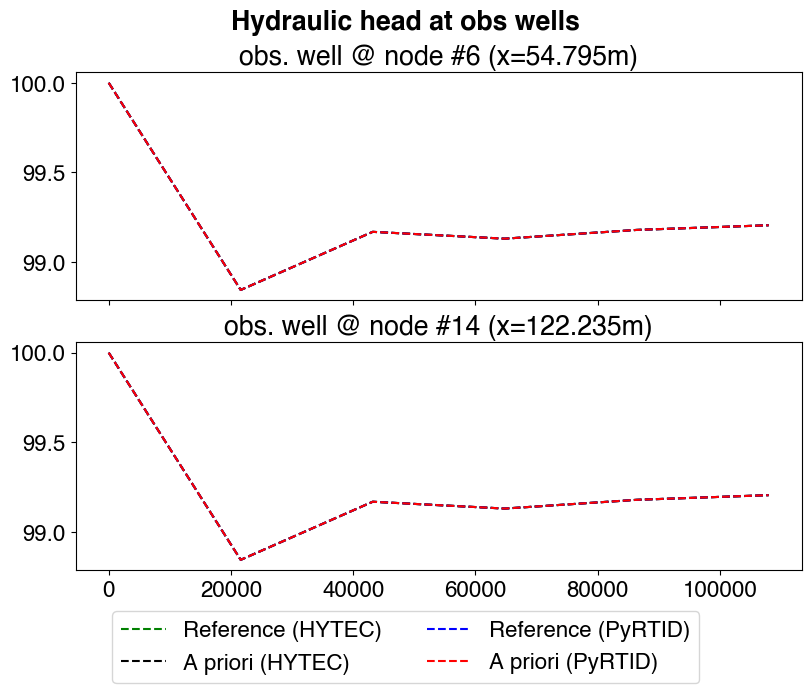

In [90]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, (ix, iy, iz) in enumerate(production_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        grid_sample_times,
        head_reference_hytec[ix, iy, iz, :],
        label="Reference (HYTEC)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        head_estimate_hytec[ix, iy, iz, :],
        label="A priori (HYTEC)",
        c="k",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        model_reference.fl_model.head[ix, iy, :],
        label="Reference (PyRTID)",
        c="b",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        model_estimate.fl_model.head[ix, iy, :],
        label="A priori (PyRTID)",
        c="r",
        linestyle="--",
    )

plotter.fig.suptitle("Hydraulic head at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "head_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

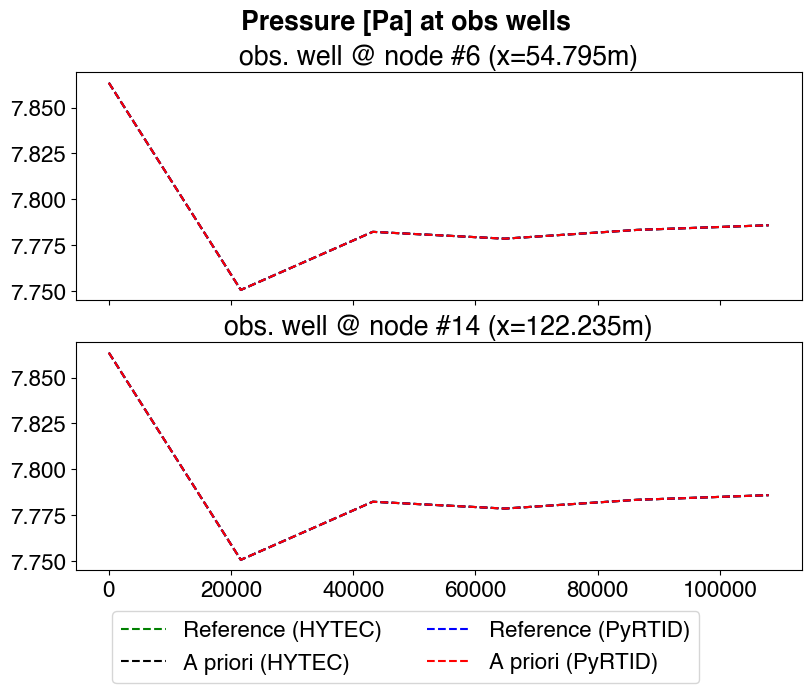

In [91]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, (ix, iy, iz) in enumerate(production_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        grid_sample_times,
        pressure_reference_hytec[ix, iy, iz, :],
        label="Reference (HYTEC)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        pressure_estimate_hytec[ix, iy, iz, :],
        label="A priori (HYTEC)",
        c="k",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        model_reference.fl_model.get_pressure_bar()[ix, iy, :],
        label="Reference (PyRTID)",
        c="b",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        model_estimate.fl_model.get_pressure_bar()[ix, iy, :],
        label="A priori (PyRTID)",
        c="r",
        linestyle="--",
    )

plotter.fig.suptitle("Pressure [Pa] at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "head_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Inversion

- Create a function to add some noise to the observations

In [92]:
noise_std: float = 3e-4  # This is an absolute value
rng = np.random.default_rng(2021)


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return rng.normal(mean_noise, noise_std, shape)


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(
    (len(production_locations), fwd_conc_estimate_hytec.shape[-1])
)

- Check the intensity of the noise

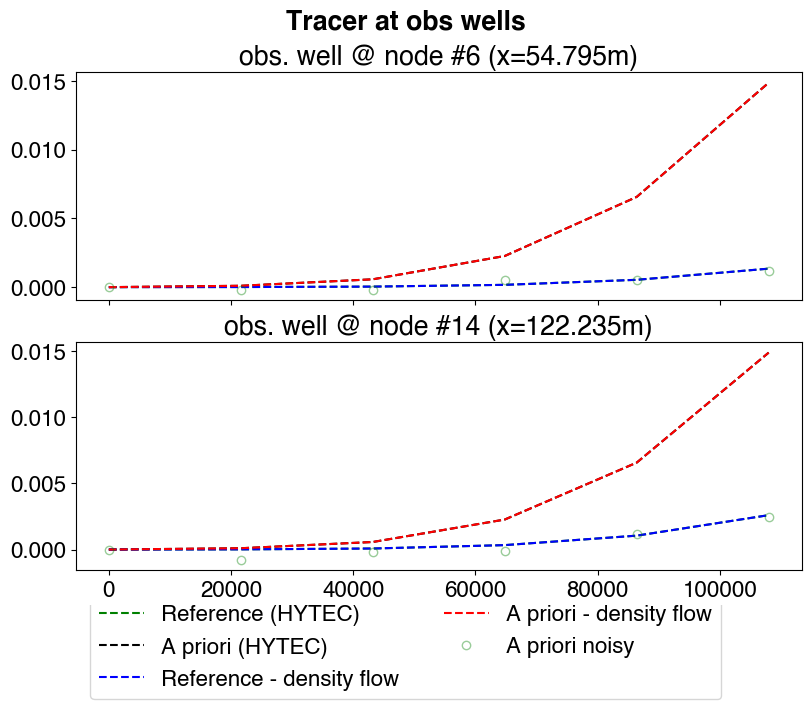

In [93]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, (ix, iy, iz) in enumerate(production_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)

    ax.plot(
        grid_sample_times,
        fwd_conc_reference_hytec[ix, iy, iz, :],
        label="Reference (HYTEC)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        fwd_conc_estimate_hytec[ix, iy, iz, :],
        label="A priori (HYTEC)",
        c="k",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        model_reference.tr_model.conc[ix, iy, :],
        label="Reference - density flow",
        c="b",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times,
        model_estimate.tr_model.conc[ix, iy, :],
        label="A priori - density flow",
        c="r",
        linestyle="--",
    )

    ax.plot(
        grid_sample_times,
        fwd_conc_reference_hytec[ix, iy, iz, :] + obs_noise[i],
        label="A priori noisy",
        c="g",
        linestyle="none",
        marker="o",
        mfc="none",
        alpha=0.4,
    )


plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Calcul des fonctions objectives:

### Inversion of non-density flow from pressure

In [103]:
# 1) Copy the base simulation
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

# 2) Add the observation wells
for count, (ix, iy, iz) in enumerate(production_locations):
    x: float = (ix + 0.5) * dx
    y: float = (iy + 0.5) * dy
    z: float = (iz + 0.5) * dz
    zone_name = f"producer_{ix}_{iy}_{iz}"

    vals = fwd_conc_reference_hytec[ix, iy, iz, :] + obs_noise[count]

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable="T",
        units="mol/s",
        timesteps=grid_sample_times,
        time_units="s",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.repeat(
            indices_to_hytec_node_number(ix=ix, nx=nx, iy=iy, ny=ny, iz=iz), vals.size
        ),
    )
    simu_inverse.register_observable(
        zone_name, obs, obs_file_path=f"observables/{zone_name}_{species}_o.dat"
    )

# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb",
        hymd.AdjointStateStatus("enabled"),
        hymd.FdGradientCheck("initial"),
    ),
    hymd.AdjustedParameterConfig(
        "porosity",
        hymd.Lbound(0.05, units="m/s"),
        hymd.Ubound(0.9, units="m/s"),
    ),
)
simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(nt)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

INFO:root:The job is over ! Elapsed time = 0:00:06.941170


- Read adjoint variable + gradient

In [105]:
ahead = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{head} []", nx=nx, ny=ny
)

# Get the HYTEC  Adj gradient
fd_gradient = simu_inverse.handlers.results.get_fd_gradient(
    param_name="porosity", nx=nx, ny=ny
)
adjoint_gradient = simu_inverse.handlers.results.get_adjoint_gradient(
    param_name="porosity", nx=nx, ny=ny
)

### Inversion PyRTID

In [106]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.POROSITY,
    lbounds=0.05,
    ubounds=0.9,
)


observables = []
for i, (ix, iy, iz) in enumerate(production_locations):
    vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
    timesteps = np.arange(vals.shape[0])

    observables.append(
        dminv.Observable(
            state_variable=dminv.StateVariable.CONCENTRATION,
            location=(slice(ix, ix + 1, 1), slice(iy, iy + 1)),
            timesteps=timesteps,
            values=vals,
            uncertainties=noise_std,
        )
    )


# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=True,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)


executor.eval_scaled_loss(param.preconditioner(param.values))

is_grad_ok = executor.is_adjoint_gradient_correct()

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 2313.2527844845877
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0004322917091928665
INFO:root:Loss (scaled)         = 1.0



In [107]:
logging.info(f"is grad ok = {is_grad_ok}")

INFO:root:is grad ok = True


In [108]:
scaling_factor = executor.inv_model.scaling_factor

In [109]:
executor.adj_model.a_tr_model.a_conc[:, :, -1].ravel("F")

array([1.20903555e-02, 2.98544469e-01, 6.52942213e+00, 1.15819185e+02,
       1.79174553e+03, 2.75244234e+04, 3.73225469e+05, 1.76258580e+04,
       8.04517497e+02, 3.05598645e+01, 8.59969238e-01, 2.77155177e+01,
       7.29637357e+02, 1.59853384e+04, 3.38487660e+05, 2.49625988e+04,
       1.62497954e+03, 1.05039362e+02, 5.92169882e+00, 2.70757565e-01,
       1.09650511e-02, 2.41984613e-01, 6.50105920e+00, 1.48945518e+02,
       2.62527300e+03, 3.85294052e+04, 5.25772042e+05, 5.94176174e+06,
       4.01278934e+05, 2.29842150e+04, 9.99079760e+02, 3.20211758e+01,
       9.06090823e+02, 2.08449685e+04, 3.63930060e+05, 5.38873467e+06,
       4.76836022e+05, 3.49432965e+04, 2.38092678e+03, 1.35082474e+02,
       5.89597576e+00, 2.19461988e-01, 2.28664327e+00, 7.59869396e+01,
       1.94262255e+03, 3.36579107e+04, 4.53515746e+05, 4.94210573e+06,
       4.05450683e+07, 4.34254923e+06, 3.44719141e+05, 1.85339631e+04,
       7.56655001e+02, 1.68089221e+04, 3.12634546e+05, 3.93836822e+06,
      

In [110]:
executor.adj_model.a_tr_model.a_conc[:, :, -2].ravel("F")

array([2.30847944e-01, 4.92606638e+00, 9.21331355e+01, 1.36947707e+03,
       1.72528962e+04, 2.06491885e+05, 2.03690538e+06, 1.33257398e+05,
       7.82553957e+03, 3.66091110e+02, 1.23135531e+01, 3.31772385e+02,
       7.09092526e+03, 1.20721528e+05, 1.84458735e+06, 1.87064976e+05,
       1.56331494e+04, 1.24108457e+03, 8.35038647e+01, 4.46502578e+00,
       2.09255145e-01, 4.00835857e+00, 9.13542121e+01, 1.74982725e+03,
       2.50931229e+04, 2.87322817e+05, 2.84611219e+06, 2.05156731e+07,
       2.19150423e+06, 1.72878059e+05, 9.63485314e+03, 3.78990477e+02,
       8.73033218e+03, 1.56614161e+05, 1.98459243e+06, 1.85639361e+07,
       2.57736107e+06, 2.60289612e+05, 2.27371759e+04, 1.58576861e+03,
       8.27976669e+01, 3.63321180e+00, 3.25356600e+01, 8.95763424e+02,
       1.85658796e+04, 2.51093827e+05, 2.47411390e+06, 1.73823867e+07,
       6.81379350e+07, 1.53993329e+07, 1.88799332e+06, 1.38381560e+05,
       7.19376334e+03, 1.25362056e+05, 1.70974405e+06, 1.39351311e+07,
      

- Plot the gradients

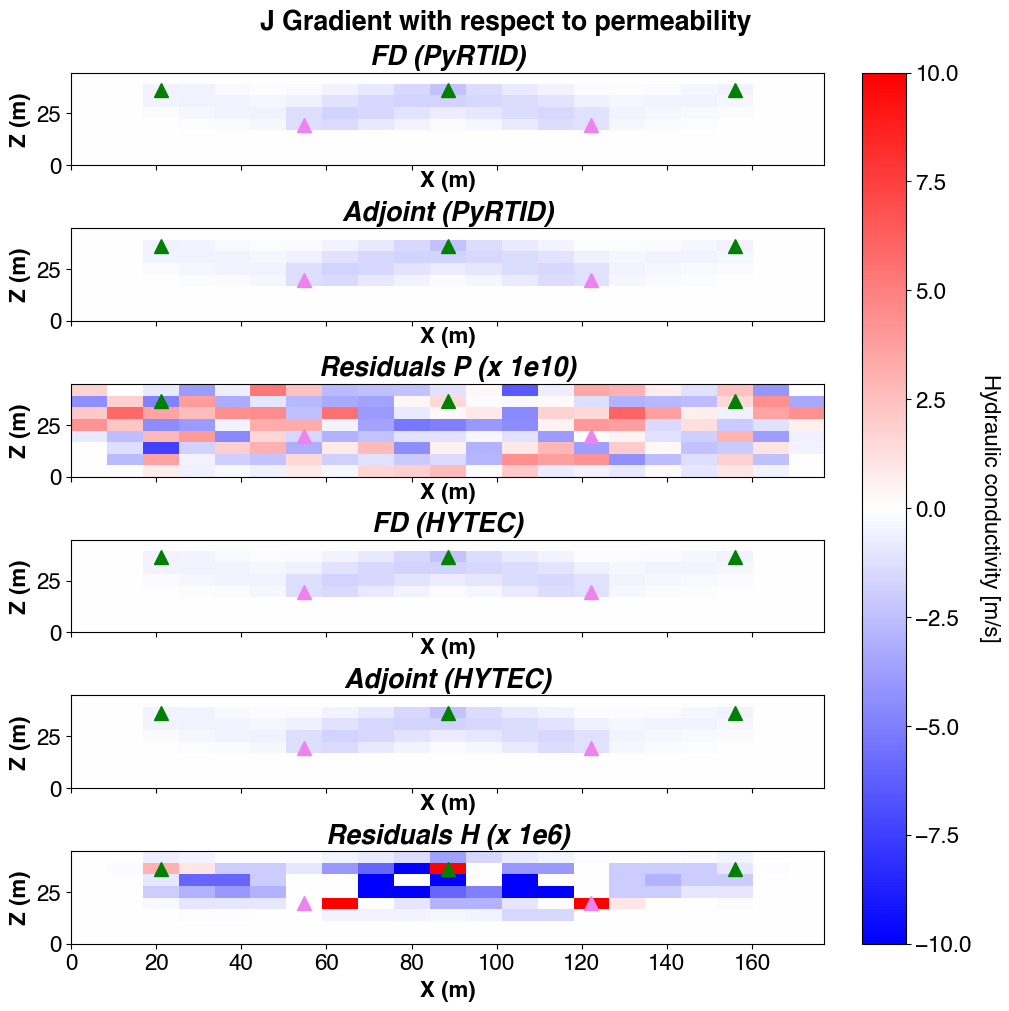

In [116]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"], ["ax1-4"], ["ax1-5"], ["ax1-6"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "FD (PyRTID)": param.grad_fd_history[0] * scaling_factor,
        "Adjoint (PyRTID)": param.grad_adj_history[0] * scaling_factor,
        "Residuals P (x 1e10)": (
            (param.grad_fd_history[0] - param.grad_adj_history[0]) * scaling_factor
        )
        * 1e10,
        "FD (HYTEC)": fd_gradient[:, :, 0, 0],
        "Adjoint (HYTEC)": adjoint_gradient[:, :, 0, 0],
        "Residuals H (x 1e6)": (adjoint_gradient[:, :, 0, 0] - fd_gradient[:, :, 0, 0])
        * 1e6,
    },
    cbar_title="Hydraulic conductivity [m/s]",
    imshow_kwargs={
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Z [m]",
    is_symmetric_cbar=True,
)

plotter.subfigs["fig0"].suptitle(
    "J Gradient with respect to permeability", fontweight="bold"
)

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

fname = "j_gradient_permeability"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)